# **Introduction**
The goal of this tutorial is to get you familiar with the ways in which positional information is used in graph neural networks. We will firstly look at superpixel MNIST, which groups pixels by similarity in order to create a graph. Then, we will apply steerable methods to MD17, a 3D dataset of molecular relaxation trajectories. 

This tutorial was created by Putri van der Linden and Rob Hesselink. If you would like to know more about these methods, feel free to contact us at

[r.d.hesselink@uva.nl](mailto:r.d.hesselink@uva.nl) \\
[p.a.vanderlinden@uva.nl](mailto:p.a.vanderlinden@uva.nl)

\\



Below you can find several papers that we recommend, if you're interested in some more reading. 

[Neural Message Passing for Quantum Chemistry](https://arxiv.org/pdf/1704.01212.pdf)

[Directional Message Passing for Molecular Graphs](https://arxiv.org/abs/2003.03123)

[E(3)-Equivariant Graph Neural Networks for Data-Efficient and Accurate Interatomic Potentials](https://arxiv.org/abs/2101.03164)







# **0. Graphs in Machine Learning**

Graph representations emerge in many machine learning domains; think for example about social networks, where users can represent nodes and edges can represent different types of interactions/relationships between them, or molecular property prediction, where atoms can be connected with eachother with various types of bonds, and the entire structure represents a molecule that, depending on the state/positions of the atoms, can emit different properties. 



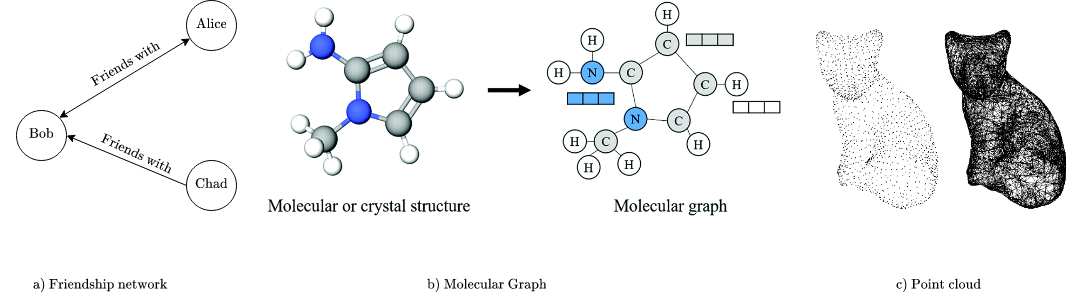


One might want to predict some global properties of the graph, i.e., given a point cloud, what object does its graph representation represent? (Classification) What is the force of a given molecule? (Regression), Or we can calculate local properties, i.e. find some new enriched node/neighborhood representation that take into account the local connectivity for each node/neighborhood.

Let us first consider a generic graph consisting of a node set $\mathcal{V}$ containing nodes $v_i$ and its connectivity given by an edge set $\mathcal{E}$ consisting of edges connecting some nodes $v_i, v_j \in \mathcal{V}$, i.e. $e_{ij} = (v_i, v_j)$ for directed graphs, $e_{ij} = \{v_i, v_j\}$ for undirected graphs, and $e_{ij} = (v_i, v_j, w_{ij})$, $e_{ij} = (\{v_i, v_j\}, w_{ij})$ for directed- and undirected weighted graphs, respectively.



# **0.5. Graphs as objects embedded in Euclidean Space**

In social network graphs, the data is purely described in terms of node types and their connections to other nodes, but there is no notion of "position" for each node. 

However, there are some domains where there actually is some positional structure between nodes, and we would do best to make use of that structure when building our models. Think for example about molecules, where the relative positions of atoms to each other carry a lot of information about the properties of the molecule. Likewise, in the point cloud example, the task is defined by the positions of the nodes in $\mathbb{R}^3$.

In this tutorial we are going to look at graph convolution methods that can act on graphs embedded in some Euclidean space, meaning that the graph represents some n-dimensional structure, and we will refer to it as a **Geometric Graph**. 




**Geometric Graphs**: Consider a multi-channel feature map $f:\mathcal{X} \rightarrow \mathbb{R}^c$ on a manifold $\mathcal{X}$ that assigns a $c$-dimensional feature vector to each point in $\mathcal{X}$. We consider a manifold graph to be a sparse point-cloud representation of such a feature map through a collection of $n$ point-value pairs $\{({x}_i, f(x_i)\}_{i=1}^n$ with $x_i \in \mathcal{X}$. The collection of node positions and corresponding values are denoted with the ordered sets $X = \{x_i\}_{i=1}^n$ and $F = \{f_i\}_{i=1}^n$. The point cloud is treated as a graph in which the point-value pairs are referred to as nodes $v_i = (x_i, f(x_i))$ and in which edges $e_{ij} \in E$ connects pairs of nodes. We refer to a manifold graph using the tuple $G = (X, F, E)$.



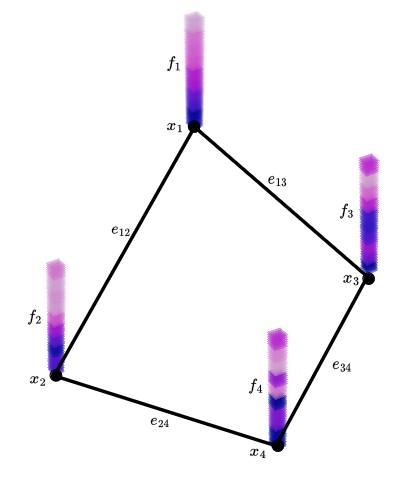

# **1. Message Passing Neural Networks**

(In the current section we will follow the message passing framework as introduced in
[Neural Message Passing for Quantum Chemistry](https://arxiv.org/pdf/1704.01212.pdf).)

ConvNets proved to be of great importance in image processing due to the fact that they explicitly incorporate structural symmetries of the domain (i.e. translation equivariance). Likewise, in graphs we need to be aware of such symmetries, which in this case is invariance to graph isomorphisms. That is, graphs that share the same connectivity are considered equivalent. See the following for an example:



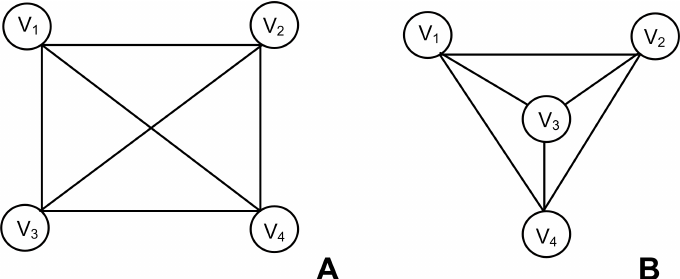

(image from: https://www.researchgate.net/publication/51083566_Using_graph_theory_to_analyze_biological_networks)

To this end we will be looking at a general MPNN framework, which respects this assumption on the domain, and look at various flavours that respect the geometry of the object at hand to different extents. Let us first consider the general MPNN framework, of which the forward pass consists of two phases: 

*  **the message passing phase**: In this phase *local* representations are built on the nodes based on neighbourhoods through the graph connectivity. These local representations are built on the nodes by propagating messages from neighbouring nodes in the following fashion:

$$ \begin{align*}
 m_{ij} &= \phi_e(f_i^l, f_j^l, a_{ij}) \quad{\text{Construct messages from neighbour nodes $j$ to center node $i$ (build edge representations)}}\\
 m_i &=  \sum_{j \in \mathcal{N}(i)} m_{ij}  \quad{\text{permutation invariant aggregation of the neighbour messages}}\\
f_i^{l+1} &= \phi_f(f_i^l, m_i)  \quad{\text{Update the center node representation based on the aggregated messages}}\end{align*}
$$

$\phi_e$ and $\phi_f$ are differentiable edge embedding and node embedding functions, respectively. $a_{ij}$ can contain additional edge attributes. By composing multiple of such operators, node representations can be built that can aggregate information over increasingly larger hop neighbourhoods.


*  **the readout phase**: constructs a *global* representation based on the all the nodes in graph after the final message passing step at $t$. This phase needs to be invariant to node permutations in order to ensure invariance to graph isomorphism. 

$$\begin{align*}
\hat{y} &= R(\{f^t_v| v \in V\})
\end{align*}$$

Where $R$ is usually some pooling (i.e. mean, max, add) on all the nodes.



## **1.2. PyTorch Geometric Recap: Deep learning for graph processing**

In this tutorial we are going to use Pytorch Geometric (PyG) to implement the message passing modules. Let's first do a quick recap on how to represent graphs in PyG. Assume we have the following (undirected) graph on the left. Its PyG representation will consist of 2d-arrays as is shown on the right. The ordering/indexing of the nodes along the rows in x and pos is tied to all node attributes, and the edge_index represents the row index of the source node in its first column to the index of the target node in its second. Similarly, the graph could be extended with edge attributes, where the indexing of the edge_index array is tied to an edge attribute array.



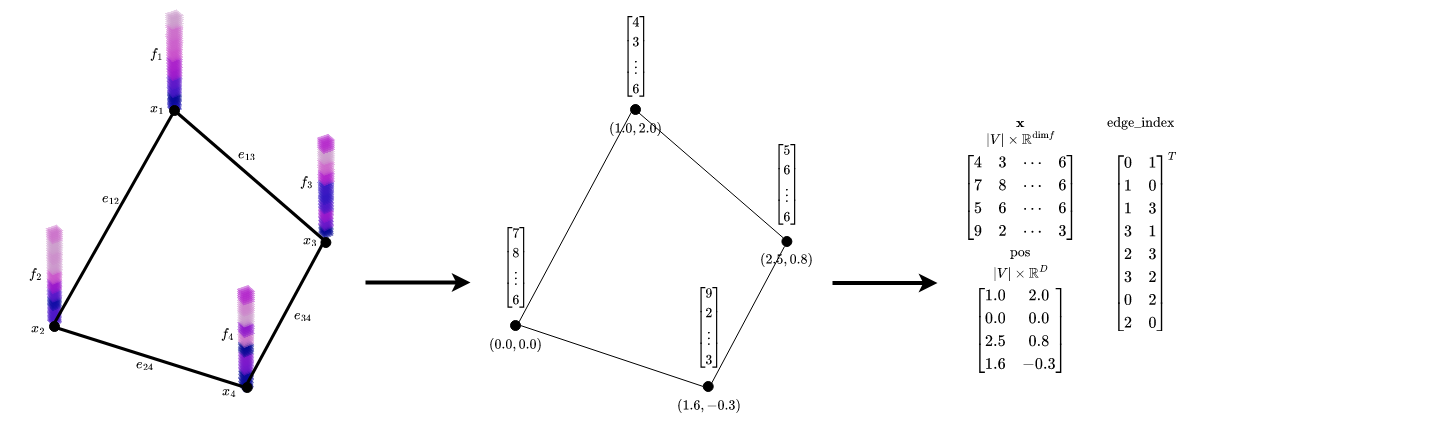

For a more extensive readup on how to represent graphs in PyG, we recommend [the official PyG docs](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html) and [this UvA DLC reference](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html#PyTorch-Geometric).

### Let's look at Message passing in Torch Geometric
First install and import the relevant packages:

In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__ # '1.9.1+cu111'
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

In [ ]:
%%capture 
# Let's install!
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html 
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install pytorch_lightning
!pip install wandb
!pip install e3nn
!pip install vapeplot

In [ ]:
# Import the most important things
import math
import numpy as np
import networkx
import matplotlib.pyplot as plt
import vapeplot
import pytorch_lightning as pl
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
from e3nn import o3
from e3nn.o3 import Irreps
from torch_scatter import scatter_mean
import io
import PIL

from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool
from torch_geometric.datasets import MD17
from torch_geometric.transforms import RadiusGraph, Compose, BaseTransform, Distance, Cartesian, RandomRotate
from torch_geometric.loader import DataLoader

from tqdm import tqdm

import torch_geometric as tg
import networkx as nx
import torchvision

import os

cmap = vapeplot.cmap('crystal_pepsi')

pl.seed_everything(42, workers=True)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

### Message Passing in PyG

You can see an implementation of the model in 1.0 in the code block below. We use Pytorch Geometric to realise these models, which greatly simplifies the implementation by doing the necessary scattering and aggregating in the background. The functions $\phi_e$ and $\phi_f$ are implemented by one layer MLPs, which are sufficient for solving the problems we'll deal with today. 

In [ ]:
class MPNNLayer(MessagePassing):
    """ Message Passing Layer """
    def __init__(self, node_features, edge_features, hidden_features, out_features, aggr, act):
        super().__init__(aggr=aggr)

        self.message_net = nn.Sequential(nn.Linear(2 * node_features + edge_features, hidden_features),
                                         act(),
                                         nn.Linear(hidden_features, hidden_features))
    
        self.update_net = nn.Sequential(nn.Linear(node_features + hidden_features, hidden_features),
                                        act(),
                                        nn.Linear(hidden_features, out_features))
    

    def forward(self, x, edge_index, edge_attr=None):
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return x

    def message(self, x_i, x_j, edge_attr):
        """ Construct messages between nodes """
        input = [x_i, x_j] if edge_attr is None else [x_i, x_j, edge_attr]
        input = torch.cat(input, dim=-1)
        message = self.message_net(input)
        return message

    def update(self, message, x):
        """ Update node features """
        input = torch.cat((x, message), dim=-1)
        update = self.update_net(input)
        return update


class MPNN(nn.Module):
    """ Message Passing Neural Network """
    def __init__(self, node_features, edge_features, hidden_features, out_features, num_layers, aggr, act, pool=None):
        super().__init__()

        self.embedder = nn.Sequential(nn.Linear(node_features, hidden_features),
                                      act(),
                                      nn.Linear(hidden_features, hidden_features))
    

        layers = []
        for i in range(num_layers):
            layer = MPNNLayer(node_features=hidden_features, 
                            hidden_features=hidden_features, 
                            edge_features=edge_features,  
                            out_features=hidden_features, 
                            aggr=aggr, 
                            act=act)
            layers.append(layer)
        self.layers = nn.ModuleList(layers)

        if pool is None:
            self.pooler = None
        elif pool == "add":
            self.pooler = global_add_pool
        elif pool == "mean":
            self.pooler = global_mean_pool
        else:
            raise Exception("Pooler not recognized")

        self.head = nn.Sequential(nn.Linear(hidden_features, hidden_features),
                                  act(),
                                  nn.Linear(hidden_features, out_features))

    def forward(self, x, edge_index, batch, edge_attr=None):
        x = self.embedder(x)

        for layer in self.layers:
            x = layer(x, edge_index, edge_attr) 
        
        if self.pooler:
            x = self.pooler(x, batch)
        
        x = self.head(x)
        return x


    def get_pre_pool_rep(self, x, edge_index, edge_attr=None):
        with torch.no_grad():            
            x = self.embedder(x)

            for layer in self.layers:
                x = layer(x, edge_index, edge_attr)
        
        return x


# **3. 2D Data: Superpixel MNIST**

Superpixel MNIST contains 2D graph representations where nodes correspond to the centers of superpixel patches (pixels grouped together according to similarity) and edges with maximum length 8. We will do graph classification on this dataset.

The message passing scheme as described in 2 does not explicitly take the geometric structure between the nodes into account; they act only on the feature vectors $f_i$ on the nodes, but not their position (that is, any structure between their position vectors $x_i$). For example, the current MPNN scheme is invariant to rotations and distance between nodes,
and hence immediately discards this information when building the node representations.

We will build node representation that respect the geometry of the manifold on which the graph lives. We will do this by injecting various geometric quantities into the edge embeddings, for example the distance between nodes, or their relative position. These choices are invariant/equivariant with respect to different groups and we will vary the input to explore how feature vectors transform under rotations. 

In [ ]:
if not os.path.exists("./datasets"):
    os.mkdir("./datasets")

batch_size = 64
radius = 8


# Regular dataloaders
transforms = RadiusGraph(radius)
train_set = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=True)
val_set = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=False)

train_loader = tg.loader.DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = tg.loader.DataLoader(val_set, batch_size=batch_size, shuffle=False) 


# Dataloaders with distance edge attributes
dist_transforms = Compose([RadiusGraph(radius), Distance()])
train_set_dist = tg.datasets.MNISTSuperpixels(root='./datasets', transform=dist_transforms, train=True)
val_set_dist = tg.datasets.MNISTSuperpixels(root='./datasets', transform=dist_transforms, train=False)

train_loader_dist = tg.loader.DataLoader(train_set_dist, batch_size=batch_size, shuffle=False)
val_loader_dist = tg.loader.DataLoader(val_set_dist, batch_size=batch_size, shuffle=False)


# Dataloaders with relative position edge attributes
relpos_transforms = Compose([RadiusGraph(radius), Cartesian()])
train_set_relpos = tg.datasets.MNISTSuperpixels(root='./datasets', transform=relpos_transforms, train=True)
val_set_relpos = tg.datasets.MNISTSuperpixels(root='./datasets', transform=relpos_transforms, train=False)

train_loader_relpos = tg.loader.DataLoader(train_set_relpos, batch_size=batch_size, shuffle=False)
val_loader_relpos = tg.loader.DataLoader(val_set_relpos, batch_size=batch_size, shuffle=False)

# image mnist for visualizations
train_set_regular = torchvision.datasets.MNIST(root='./datasets', train=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), download=True)
val_set_regular = torchvision.datasets.MNIST(root='./datasets', train=False, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), download=True)


print(train_set[0])
print(train_set_dist[0])
print(train_set_relpos[0])

Extracting datasets/raw/MNISTSuperpixels.zip
Processing...
Done!


100%|██████████| 9912422/9912422 [00:00<00:00, 30041273.98it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105427061.64it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23424562.97it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4338539.92it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Data(x=[75, 1], edge_index=[2, 1198], y=[1], pos=[75, 2])
Data(x=[75, 1], edge_index=[2, 1198], y=[1], pos=[75, 2], edge_attr=[1198, 1])
Data(x=[75, 1], edge_index=[2, 1198], y=[1], pos=[75, 2], edge_attr=[1198, 2])


 Here we can see what a datasample looks like (original image is plotted underneath):

Digit: 4


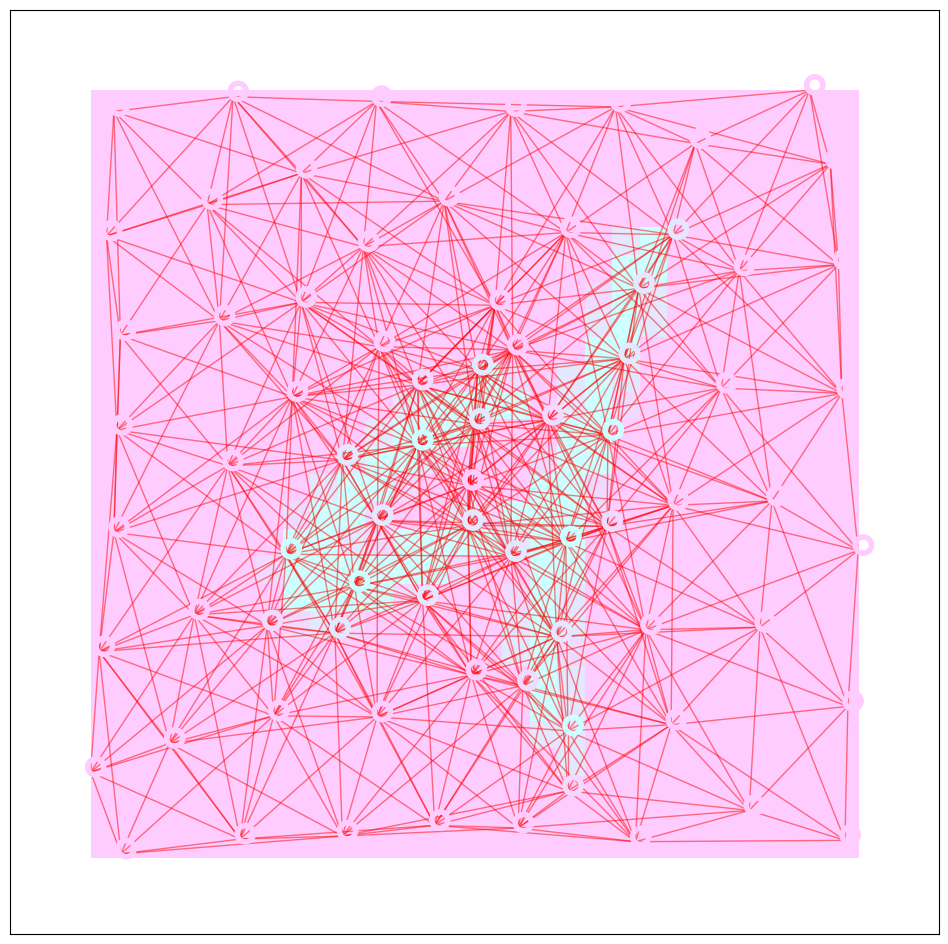

In [ ]:
def visualize_sample(idx, data, regular_data):

    
    sample_graph = data[idx].clone()
    sample_graph.pos -= sample_graph.pos.min()
    sample_graph.pos = sample_graph.pos/sample_graph.pos.max() * 2 - 1
    
    
    sample_mnist = regular_data[idx][0].squeeze(0)

    pos_dict = {}
    print(f"Digit: {sample_graph.y.item()}")
    for i, p in enumerate(sample_graph.pos):
        pos_dict[i] = p.numpy() * np.array([1, -1])

    
    g = tg.utils.to_networkx(sample_graph, to_undirected=True)

    f, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(sample_mnist.numpy(), extent=[-1,1,-1,1], cmap=cmap)
    nx.draw_networkx_nodes(g, 
                           node_size=500, 
                           node_color=sample_graph.x.cpu().numpy(), 
                           node_shape=r'$\circ$', 
                           pos=pos_dict,
                           cmap=cmap)

    nx.draw_networkx_edges(g, edge_color='r', alpha=0.5, pos=pos_dict)

visualize_sample(np.random.randint(len(train_set)), train_set, train_set_regular)


Recall that for batch processing of N graphs, PyG builds a single composite graph where the N graphs are disconnected. Hence, the batch element assigns to each node the index of which of the N graphs it belongs to.



In [ ]:
for graphs in train_loader:
    print(f"batch_shape: {graphs.batch.shape}")
    print(f"batch_size: {graphs.batch.max() + 1}")
    # the first graph has 75 nodes: hence the batch attribute assigns the first 75 nodes to the 0th graph
    print(graphs.batch[:76])
    break

batch_shape: torch.Size([4800])
batch_size: 64
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])


In the following we will train the MPNNs with three types of edge embeddings: 


*   No edge attributes
*   Euclidean distance
*   Relative distance vector

In [ ]:
class MNISTClassifier(pl.LightningModule):
    def __init__(self, model, lr, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.lr = lr
        
        self.train_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.valid_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, graph):
        if isinstance(self.model, MPNN):
            return self.model(x=graph.x, edge_index=graph.edge_index, edge_attr=graph.edge_attr, batch=graph.batch)
        elif isinstance(self.model, EGNN):
            return self.model(x=graph.x, pos=graph.pos, edge_index=graph.edge_index, batch=graph.batch)
    
    def training_step(self, graph):
        pred = self(graph).squeeze()
        loss = F.cross_entropy(pred, graph.y)
        self.train_metric(pred, graph.y)
        return loss
    
    def on_train_epoch_end(self):
        self.log("train acc", self.train_metric, prog_bar=True)
    
    def validation_step(self, graph, batch_idx):
        pred = self(graph).squeeze()
        self.valid_metric(pred, graph.y)
    
    def on_validation_epoch_end(self):
        self.log("valid acc", self.valid_metric, prog_bar=True)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

You can train these models yourself, or load from checkpoints which you can download [here](https://drive.google.com/drive/folders/1OJrpdojGTALIcxNqVkch241lQC-rrG6c?usp=sharing).

In [ ]:
n_epochs = 50
learning_rate = 1e-3
batch_size = 64

node_features = 1
hidden_features = 64
out_features = 10
num_layers = 2
aggr = "mean"
pool = "add"
act = nn.ReLU

In [ ]:
vanilla_mpnn = MPNN(node_features=node_features, 
                    edge_features=0,
                    hidden_features=hidden_features, 
                    out_features=out_features, 
                    num_layers=num_layers, 
                    aggr=aggr,
                    pool=pool,  
                    act=act)
                    

trainer_mpnn = pl.Trainer(logger=None, accelerator="gpu", max_epochs=n_epochs)
# trainer_mpnn.fit(model=MNISTClassifier(model=vanilla_mpnn, lr=learning_rate), train_dataloaders=train_loader, val_dataloaders=val_loader)
# trainer_mpnn.save_checkpoint("./vanilla_mpnn.ckpt")

# Use this for loading from a checkpoint
# trainer_mpnn.fit(model=MNISTClassifier(model=vanilla_mpnn, lr=learning_rate), train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path="./vanilla_mpnn.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
dist_mpnn = MPNN(node_features=node_features, 
                 edge_features=1,
                 hidden_features=hidden_features, 
                 out_features=out_features, 
                 num_layers=num_layers, 
                 aggr=aggr,
                 pool=pool,  
                 act=nn.ReLU)

trainer_dist = pl.Trainer(logger=None, accelerator="gpu", max_epochs=n_epochs)
# trainer_dist.fit(model=MNISTClassifier(model=dist_mpnn, lr=learning_rate), train_dataloaders=train_loader_dist, val_dataloaders=val_loader_dist)
# trainer_dist.save_checkpoint("./dist_mpnn.ckpt")

# Use this for loading from a checkpoint
# trainer_dist.fit(model=MNISTClassifier(model=dist_mpnn, lr=learning_rate), train_dataloaders=train_loader_dist, val_dataloaders=val_loader_dist, ckpt_path="./dist_mpnn.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
relpos_mpnn = MPNN(node_features=node_features, 
                   edge_features=2,
                   hidden_features=hidden_features, 
                   out_features=out_features, 
                   num_layers=num_layers, 
                   aggr=aggr,
                   pool=pool,  
                   act=act)

trainer_relpos = pl.Trainer(logger=None, accelerator="gpu", max_epochs=n_epochs)
# trainer_relpos.fit(model=MNISTClassifier(model=relpos_mpnn, lr=learning_rate), train_dataloaders=train_loader_relpos, val_dataloaders=val_loader_relpos)
# trainer_relpos.save_checkpoint("./relpos_mpnn.ckpt")

# Use this for loading from a checkpoint
# trainer_relpos.fit(model=MNISTClassifier(model=relpos_mpnn, lr=learning_rate), train_dataloaders=train_loader_relpos, val_dataloaders=val_loader_relpos, ckpt_path="./relpos_mpnn.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## 3.2 Lets visualize the learned representations under rotations

We will now look at what the representations learned after the message passing phase look like (pre-pooling) when we apply different rotations to the input. Specifically, at each node we will look at the values of the first three learned features.

In [ ]:
#@title (This cell contains some code for creating visualizations, feel free to skip over it)
import cv2
import PIL



# helper code for visualizing
def visualize_rep(pos, x, edges, ax=None):
    pos_dict = {}
    for i, p in enumerate(pos):

        pos_dict[i] = p.cpu().numpy() * np.array([1, -1])

    for i in range(x.shape[-1]):
        data = tg.data.Data(pos=pos, x=x[:, i], edge_index=edges)
        g = tg.utils.to_networkx(data, to_undirected=True)

        if i > 0:
            for key, val in pos_dict.items():
                pos_dict[key] = val + np.array([0, 0.07])
        nx.draw_networkx_nodes(g,
                               node_size=300, 
                               node_color=data.x.cpu().numpy(), 
                               node_shape=r's', 
                               ax=ax,
                               pos=pos_dict)

    nx.draw_networkx_edges(g, edge_color='r', ax=ax, alpha=0.5, pos=pos_dict)
    
    return ax

class RotateDegree(tg.transforms.RandomRotate):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, data, degree):
        
        degree = math.pi * degree / 180.0
        
        sin, cos = math.sin(degree), math.cos(degree)

        if data.pos.size(-1) == 2:
            matrix = [[cos, sin], [-sin, cos]]
        else:
            if self.axis == 0:
                matrix = [[1, 0, 0], [0, cos, sin], [0, -sin, cos]]
            elif self.axis == 1:
                matrix = [[cos, 0, -sin], [0, 1, 0], [sin, 0, cos]]
            else:
                matrix = [[cos, sin, 0], [-sin, cos, 0], [0, 0, 1]]

        
        return tg.transforms.LinearTransformation(torch.tensor(matrix))(data)


def visualize_sample_transformed(sample_graph, sample_mnist, ax=None):
    pos_dict = {}
    for i, p in enumerate(sample_graph.pos):
        pos_dict[i] = p.numpy() * np.array([1, -1])

    h = sample_mnist.shape[0] / 28
    g = tg.utils.to_networkx(sample_graph, to_undirected=True)

    ax.imshow(sample_mnist, extent=[-1.0 * h, 1.0 * h, -1.0 * h, 1.0 * h])
    nx.draw_networkx_nodes(g, 
                           node_size=300, 
                           node_color=sample_graph.x.numpy(), 
                           node_shape=r'$\circ$', 
                           ax=ax,
                           pos=pos_dict)
    
    

    nx.draw_networkx_edges(g, edge_color='r', ax=ax, alpha=0.5, pos=pos_dict)
    return ax


def plot_rotated_representations(model, original_graph, mnist_img, rotations, video_name=None, connectivity_transform=None, edge_attr_transform=None):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if video_name is None:
        video_name = 'video.avi'
    
    if not os.path.exists("./img_temp"):
        os.mkdir("./img_temp")

    image_folder = f"./img_temp/{video_name.split('.')[0]}"
    if not os.path.exists(image_folder):
        os.mkdir(image_folder)
        
        
    if not os.path.exists(image_folder + "_stabilized"):
        os.mkdir(image_folder + "_stabilized")

    if connectivity_transform is not None:
        original_graph = connectivity_transform(original_graph)
        

    # rotating representations
    with torch.no_grad():
        for i, rot in enumerate(rotations):
            fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

            # rotated view
            rot_graph = RotateDegree(degrees=180)(original_graph.clone(), degree=rot)
            
            if edge_attr_transform is not None:
                rot_graph = edge_attr_transform(rot_graph)
            rot_graph = tg.transforms.NormalizeScale()(rot_graph)

            sample_mnist = torchvision.transforms.ToPILImage()(mnist_img.clone())
            sample_mnist_rot = np.array(sample_mnist.rotate(rot))


            axes[0] = visualize_sample_transformed(rot_graph, sample_mnist_rot, axes[0])

            axes[0].set_title("input", fontsize=20)
            axes[0].set_aspect('equal', 'box')
            rot_graph = rot_graph.to(device)
            x, edge_index, pos, edge_attr = rot_graph.x, rot_graph.edge_index, rot_graph.pos, rot_graph.edge_attr

            x = model.get_pre_pool_rep(x=x, edge_index=edge_index, edge_attr=edge_attr)
            axes[1] = visualize_rep(pos=pos, x=x[:,:3], edges=edge_index, ax=axes[1])

        
            
            axes[1].set_aspect('equal', 'box')
            axes[1].set_title("pre-pool representation", fontsize=20)

    
            fig.suptitle(r"$\theta = "+ str(rot) + "^\circ$", fontsize=30)
    

            plt.savefig(f"{image_folder}/{i}.png", dpi=200)
            plt.close()
            
            fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
            
            # rotate back for stabilized view
            rot_graph = RotateDegree(degrees=180)(tg.data.Data(pos=pos, x=x, edge_index=edge_index).to(device), degree=-rot)
            rot_graph = tg.transforms.NormalizeScale()(rot_graph)

            x, edge_index, pos, edge_attr = rot_graph.x, rot_graph.edge_index, rot_graph.pos, rot_graph.edge_attr


            ax = visualize_rep(pos=pos, x=x[:,:3], edges=edge_index, ax=ax)
            
            ax.set_title("stabilized view", fontsize=20)
            
            fig.suptitle(r"$\theta = "+ str(rot) + "^\circ$", fontsize=30)
            plt.savefig(f"{image_folder}_stabilized/{i}.png", dpi=200)
            plt.close()


        images = list(range(len(rotations)))
        images = [str(i) + ".png" for i in images]

        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, 0, 10.0, (width, height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()
        
        
        frame = cv2.imread(os.path.join(image_folder + "_stabilized", images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter("stabilized_" + video_name , 0, 10.0, (width, height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder + "_stabilized", image)))

        cv2.destroyAllWindows()
        video.release()


In [ ]:
data_idx = 20
sample_mnist = train_set_regular[data_idx][0].squeeze(0)
original_graph = train_set[data_idx]
rot_ranges = list(np.linspace(0, 180, 90))


plot_rotated_representations(vanilla_mpnn, 
                             original_graph, 
                             sample_mnist, 
                             rot_ranges, 
                             "vanilla_mpnn.avi",
                             RadiusGraph(radius))

plot_rotated_representations(dist_mpnn, 
                             original_graph, 
                             sample_mnist, 
                             rot_ranges, 
                             "dist_mpnn.avi",
                             RadiusGraph(radius),
                             tg.transforms.Distance())

plot_rotated_representations(relpos_mpnn, 
                             original_graph, 
                             sample_mnist, 
                             rot_ranges, 
                             "relpos_mpnn.avi",
                             RadiusGraph(radius),
                             tg.transforms.Cartesian())

NameError: ignored

We have trained a few rotation-invariant models (the vanilla MPNN and the distance MPNN), and we indeed see that the message passing representations do not change under input rotations (the models see these all as the same object.) For the relative position MPNN, the representations do change, meaning that rotated inputs may be classified as different objects in the readout phase.

## EGNN

Introduced in [E(n) Equivariant Graph Neural Networks](https://arxiv.org/abs/2102.09844), the EGNN is a computationally efficient equivariant graph neural network. It extends the message passing equations seen previously by updating node positions. 

\begin{align}
 m_{ij} &= \phi_e(f_i^l, f_j^l, ||x_i - x_j||)\\
 x^{l+1}_i &= x^l_i + \sum_{j \in \mathcal{N}(i)} (x^l_i - x^l_j) \phi_p(m_{ij}) \\
 m_i &=  \sum_{j \in \mathcal{N}(i)} m_{ij} \\
f_i^{l+1} &= \phi_f(f_i^l, m_i) 
\end{align}

The addition here is in line two, where $\phi_p$ produces a scalar that weights how much $x_i$ moves towards or away from its neighbours. You can check for yourself that this update rule is equivariant. Note, however, that $\phi_p(m_{ij})$ depends only on the distance and is therefore invariant. However, by moving nodes closer to each other, the EGNN may learn to re-weight the extent in which they influence each other, making the model more flexible than the previous MPNNs. 

Given that points can now move around, we will need to update the graph after every position update. The code below has been left partially empty as an exercise for the reader. Please implement the message and update methods `EGNNLayer`. Hint: we can aggregate the position updates together with the standard messages by concatenating them at the end of the `message` function. 

In [ ]:
class EGNNLayer(MessagePassing):
    """ E(n)-equivariant Message Passing Layer """
    def __init__(self, node_features, edge_features, hidden_features, out_features, dim, aggr, act):
        super().__init__(aggr=aggr)
        self.dim = dim

        self.message_net = nn.Sequential(nn.Linear(2 * node_features + edge_features, hidden_features),
                                         act(),
                                         nn.Linear(hidden_features, hidden_features))
    
        self.update_net = nn.Sequential(nn.Linear(node_features + hidden_features, hidden_features),
                                        act(),
                                        nn.Linear(hidden_features, out_features))
        
        self.pos_net = nn.Sequential(nn.Linear(hidden_features, hidden_features),
                                     act(),
                                     nn.Linear(hidden_features, 1))
        
        nn.init.xavier_uniform_(self.pos_net[-1].weight, gain=0.001)

    

    def forward(self, x, pos, edge_index, edge_attr=None):

        x = self.propagate(edge_index, x=x, pos=pos, edge_attr=edge_attr)
        return x

    def message(self, x_i, x_j, pos_i, pos_j, edge_attr):
        """ Create messages """
        input = [x_i, x_j] if edge_attr is None else [x_i, x_j, edge_attr]
        input = torch.cat(input, dim=-1)
        message = self.message_net(input)

        pos_message = (pos_i - pos_j)*self.pos_net(message)
        message = torch.cat((message, pos_message), dim=-1)
        return message

    def update(self, message, x, pos):
        """ Update node features and positions """
        node_message, pos_message = message[:, :-self.dim], message[:, -self.dim:]
        # Update node features
        input = torch.cat((x, node_message), dim=-1)
        update = self.update_net(input)
        # Update positions
        pos += pos_message
        return update, pos

class EGNN(nn.Module):
    """ E(n)-equivariant Message Passing Network """
    def __init__(self, node_features, hidden_features, out_features, num_layers, dim, radius, aggr, act, pool=None):
        super().__init__()
        edge_features = 1
        self.dim = dim
        self.radius = radius

        self.embedder = nn.Sequential(nn.Linear(node_features, hidden_features),
                                      act(),
                                      nn.Linear(hidden_features, hidden_features))
        
       
    
        layers = []
        for i in range(num_layers):
            layers.append(EGNNLayer(hidden_features, edge_features, hidden_features, hidden_features, dim, aggr, act))
        self.layers = nn.ModuleList(layers)

        if pool is None:
            self.pooler = None
        elif pool == "add":
            self.pooler = global_add_pool
        elif pool == "mean":
            self.pooler = global_mean_pool
        else:
            raise Exception("Pooler not recognized")

        self.head = nn.Sequential(nn.Linear(hidden_features, hidden_features),
                                  act(),
                                  nn.Linear(hidden_features, out_features))

    def forward(self, x, pos, edge_index, batch):
        x = self.embedder(x)

        dist = torch.sum((pos[edge_index[1]] - pos[edge_index[0]]).pow(2), dim=-1, keepdim=True).sqrt()
        edge_attr = dist
       
        for layer in self.layers:
            x, pos = layer(x, pos, edge_index, dist) 

            # Update graph
            if self.radius:
                edge_index = tg.nn.radius_graph(pos, self.radius, batch)
                dist = torch.sum((pos[edge_index[1]] - pos[edge_index[0]]).pow(2), dim=-1, keepdim=True).sqrt()
        
        if self.pooler:
            x = self.pooler(x, batch)
        
        x = self.head(x)
        return x

In [ ]:
egnn = EGNN(node_features=node_features, 
            hidden_features=hidden_features, 
            out_features=out_features, 
            num_layers=num_layers, 
            dim=2,
            radius=radius,
            aggr=aggr,
            pool=pool,  
            act=act)


trainer_egnn = pl.Trainer(logger=None, accelerator="gpu", max_epochs=n_epochs)
# trainer_egnn.fit(MNISTClassifier(model=egnn, lr=learning_rate), train_dataloaders=train_loader, val_dataloaders=val_loader)
# trainer_egnn.save_checkpoint("./egnn.ckpt")

# Use this for loading from a checkpoint
# trainer_egnn.fit(model=MNISTClassifier(model=egnn, lr=learning_rate), train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path="./egnn.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Let's see how these models perform under rotation augmentations

In [ ]:
augmentation = RandomRotate(180)

# Regular dataloaders
transforms = Compose([RadiusGraph(radius), augmentation])
val_set_aug = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=False)
val_loader_aug = tg.loader.DataLoader(val_set_aug, batch_size=batch_size, shuffle=False)

# Dataloaders with distance edge attributes
dist_transforms = Compose([RadiusGraph(radius), augmentation, Distance()])
val_set_dist_aug = tg.datasets.MNISTSuperpixels(root='./datasets', transform=dist_transforms, train=False)
val_loader_dist_aug = tg.loader.DataLoader(val_set_dist_aug, batch_size=batch_size, shuffle=False)

# Dataloaders with relative position edge attributes
relpos_transforms = Compose([RadiusGraph(radius), augmentation, Cartesian()])
val_set_relpos_aug = tg.datasets.MNISTSuperpixels(root='./datasets', transform=relpos_transforms, train=False)
val_loader_relpos_aug = tg.loader.DataLoader(val_set_relpos_aug, batch_size=batch_size, shuffle=False)

In [ ]:
trainer_mpnn.validate(MNISTClassifier(model=vanilla_mpnn, lr=learning_rate), dataloaders=val_loader_aug, ckpt_path="./vanilla_mpnn.ckpt")
trainer_dist.validate(MNISTClassifier(model=dist_mpnn, lr=learning_rate), dataloaders=val_loader_dist_aug, ckpt_path="./dist_mpnn.ckpt")
trainer_relpos.validate(MNISTClassifier(model=relpos_mpnn, lr=learning_rate), dataloaders=val_loader_relpos_aug, ckpt_path="./relpos_mpnn.ckpt")
trainer_egnn.validate(MNISTClassifier(model=egnn, lr=learning_rate), dataloaders=val_loader_aug, ckpt_path="./egnn.ckpt")


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./vanilla_mpnn.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./vanilla_mpnn.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         valid acc         │     0.743399977684021     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./dist_mpnn.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./dist_mpnn.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         valid acc         │    0.8540999889373779     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./relpos_mpnn.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./relpos_mpnn.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         valid acc         │    0.41370001435279846    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./egnn.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./egnn.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         valid acc         │    0.8842999935150146     │
└───────────────────────────┴───────────────────────────┘

[{'valid acc': 0.8842999935150146}]

So far we have seen how incorporating structural information between nodes in terms of relative positions and distances can make a model robust against rotations and incorporate information from orientations. How do you think these models will perform under other transformations, for example, scaling and reflections of the input? We encourage you to reason about it and test your assumption by validating these models on differently augmented datasets. Many of these transforms are readily available in [the PyG transforms module](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html) (i.e. RandomScale, RandomFlip...)

# 4. 3D Data: MD17

For the second part of this tutorial we'll move our attention to graphs in 3D space. Similarly to the previous data set, positional information is very important for the prediction of chemical properties. 

The MD17 dataset consists of relaxation trajectories of small molecules. We will be looking at aspirin today. The task is to either predict the net force on each atom, or the total energy of the configuration. In the section below you can find some code to plot different versions of that same molecule and you might even need to look twice to spot the differences. This is what makes the data set so hard for invariant methods. There will only be very small differences in the pairwise distances, making it hard to distinguish graphs. We'll apply the MPNN, an EGNN and the SEGNN.

In [ ]:
radius = 2

class OneHotTransform(BaseTransform):
    def __call__(self, graph):
        graph.z = F.one_hot(graph.z).float()
        return graph


transforms_dist = Compose([RadiusGraph(r=radius), OneHotTransform(), Distance()])
train_dataset = MD17(root="./datasets", name="aspirin CCSD", train=True, transform=transforms_dist)
valid_dataset = MD17(root="./datasets", name="aspirin CCSD", train=False, transform=transforms_dist)

In [ ]:
#@title (This cell contains some code for creating visualizations, feel free to skip over it) 
axis = dict(
    showbackground=False,
    showticklabels=False,
    showgrid=False,
    zeroline=False,
    title='',
)

layout = dict(
    showlegend=False,
    scene=dict(
        aspectmode="data",
        xaxis=dict(
            **axis,
        ),
        yaxis=dict(
            **axis,
        ),
        zaxis=dict(
            **axis,
        ),
    ),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    margin=dict(l=0, r=0, t=0, b=0)
)

def s2_grid(N=100):
    """ Create grid on which we can sample spherical signals """
    betas = torch.linspace(0, math.pi, int(N/2))
    alphas = torch.linspace(0, 2 * math.pi, N)
    beta, alpha = torch.meshgrid(betas, alphas)
    return o3.angles_to_xyz(alpha, beta)

def nodes_to_shs(f, irreps, grid):
    """ Converts node features to irreps. """
    lmax = irreps.lmax
    N = f.size(0)

    assert len(f.shape) == 2, "We expect [N, coefficients]"
    assert irreps == Irreps.spherical_harmonics(lmax), "Irreps aren't SHs"

    shs = o3.spherical_harmonics(irreps.ls, grid, normalize=True).unsqueeze(0).repeat(N, 1, 1, 1)
    shs *= f.view(N, 1, 1, -1)
    shs = shs.sum(-1)
    return shs

def plot_spherical_harmonics(f, positions, irreps, pos_factor=1, offset=0):
    """ Plots feature vectors on molecule as spherical harmonics."""
    # Leave no trace
    f, positions = f.clone(), positions.clone()
    
    # Convert features to Spherical Harmonics
    grid = s2_grid()
    shs = nodes_to_shs(f, irreps, grid)    

    # Let's plot!
    fig = go.Figure(layout=layout)

    # Normalise
    positions -= positions.min()
    positions /= positions.max()
    positions *= pos_factor

    shs -= shs.min()
    shs /= shs.max()
    shs = shs*(1 - offset) + offset
    
    cmin = offset
    cmax = 1 

    # Plot nodes
    for sh, pos in zip(shs, positions):        
        x = sh.abs() * grid[..., 0] + pos[0]
        y = sh.abs() * grid[..., 1] + pos[1]
        z = sh.abs() * grid[..., 2] + pos[2] 

        fig.add_trace(go.Surface(x=x, y=y, z=z, surfacecolor=sh, colorscale=vapeplot.palette('crystal_pepsi'), cmin=cmin, cmax=cmax))

    # Add edges
    for (pos_i, pos_j) in positions[graph.edge_index].transpose(1, 0):
        d = dict(x=[pos_i[0], pos_j[0]],
                 y=[pos_i[1], pos_j[1]],
                 z=[pos_i[2], pos_j[2]])

        fig.add_trace(go.Scatter3d(**d,
                                   marker=dict(
                                       size=0,
                                   ),
                                   line=dict(
                                       color='black',
                                       width=6,
                                   ), opacity=0.1)
                      )

    fig.show()

In [ ]:
graph = train_dataset[np.random.randint(len(train_dataset))]
irreps = Irreps("1x0e")
plot_spherical_harmonics(graph.z.argmax(-1, keepdims=True), graph.pos, irreps, pos_factor=15, offset=0.5)

## Energy Prediction

We will start with predicting the total energy of the configuration. Below you can find a Lightning module to predict energies. It has a simple cosine annealing learning rate scheduler. Below that, I've added a cell that computes statistics over the training dataset, so the model does not spend the first few epochs learning quantities that we can easily compute ourselves. 

Note that for the statistics on forces, we use compute statistics on the norm. If we were to directly compute the average, we would have non-equivariant statistics. 

In [ ]:
class MD17Regressor(pl.LightningModule):
    def __init__(self, model, target, lr, epochs, mean=0, mad=1):
        super().__init__()
        self.model = model
        self.target = target
        self.lr = lr
        self.epochs = epochs
        self.train_metric = torchmetrics.MeanAbsoluteError()
        self.valid_metric = torchmetrics.MeanAbsoluteError()

        self.mean = mean
        self.mad = mad

    def forward(self, graph):
        if isinstance(self.model, MPNN):
            pred = self.model(graph.z, graph.edge_index, graph.batch, graph.edge_attr)
        elif isinstance(self.model, EGNN):
            # Don't add distance, as this is done internally
            pred = self.model(graph.z, graph.pos, graph.edge_index, graph.batch) 
        elif isinstance(self.model, SEGNN):
            edge_index = graph.edge_index
            pos = graph.pos
            rel_pos = pos[edge_index[1]] - pos[edge_index[0]]
            mean_rel_pos = scatter_mean(rel_pos, edge_index[0], dim=0)
            rel_pos_sh = spherical_harmonics(self.model.irreps_edge_sh, rel_pos, normalize=True, normalization="component")
            mean_rel_pos_sh = spherical_harmonics(self.model.irreps_edge_sh, mean_rel_pos, normalize=True, normalization="component")
            pred = self.model(graph.z, edge_index, graph.batch, graph.edge_attr, mean_rel_pos_sh, rel_pos_sh)
                    
        return pred

    def get_target(self, graph):
        if self.target == "energy":
            return graph.energy
        elif self.target == "force":
            return graph.force

    def training_step(self, graph):
        pred = self(graph).squeeze()
        y = self.get_target(graph)
        loss = F.l1_loss(pred, (y - self.mean)/self.mad)
        self.train_metric(pred*self.mad + self.mean, y)
        return loss

    def training_epoch_end(self, outs):
        self.log("train MAE", self.train_metric, prog_bar=True)

    def validation_step(self, graph, batch_idx):
        pred = self(graph).squeeze()
        y = self.get_target(graph)
        self.valid_metric(pred*self.mad + self.mean, y)

    def validation_epoch_end(self, outs):
        self.log("valid MAE", self.valid_metric, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr, amsgrad=True
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, self.epochs-1, verbose=False
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "epoch",
            "frequency": 1,
        }
        return [optimizer], [lr_scheduler_config]

In [ ]:
energy_mean = 0
energy_mad = 0
force_mean = 0
force_mad = 0

N_graphs = 0
N_nodes = 0

for graph in train_dataset:
    N_graphs += 1
    N_nodes += graph.num_nodes

    energy_mean += graph.energy
    force_mean += torch.linalg.vector_norm(graph.force, dim=1).sum()

energy_mean /= N_graphs
force_mean /= N_nodes

for graph in train_dataset:
    energy_mad += (energy_mean - graph.energy).abs()
    force_mad += (force_mean - torch.linalg.vector_norm(graph.force, dim=1)).abs().sum()

energy_mad /= N_graphs
force_mad /= N_nodes

energy_mean = energy_mean.item()
energy_mad = energy_mad.item()
force_mean = force_mean.item()
force_mad = force_mad.item()

print("Energy: %0.4f | %0.4f" % (energy_mean, energy_mad))
print("Force:       %0.4f | %0.4f" % (force_mean, force_mad))

Let's start with the two models we have defined previously: the MPNN and EGNN. How will they fare on this difficult task?


In [ ]:
batch_size = 32
epochs = 100
lr = 3e-4

num_layers = 3
act = nn.SiLU
aggr = "mean"
pool = "mean"

node_features = 9
edge_features = 1
hidden_features = 64
out_features = 1

In [ ]:
mpnn = MPNN(node_features, edge_features, hidden_features, out_features, num_layers, aggr, act, pool)
mpnn = MD17Regressor(mpnn, "energy", lr, epochs, energy_mean, energy_mad)

trainer = pl.Trainer(gpus=1, logger=None, max_epochs=epochs)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(train_dataset, batch_size, shuffle=False)
trainer.fit(mpnn, train_loader, valid_loader)

In [ ]:
egnn = EGNN(node_features, hidden_features, out_features, num_layers, 3, radius, aggr, act, pool)
egnn = MD17Regressor(egnn, "energy", lr, epochs, energy_mean, energy_mad)

trainer = pl.Trainer(gpus=1, logger=None, max_epochs=epochs)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(train_dataset, batch_size, shuffle=False)
trainer.fit(egnn, train_loader, valid_loader)

## SEGNN
If your results were like mine, they must have been disappointing. The models do not seem to learn anything at all. Perhaps it might be easier to learn if models could communicate direction a bit better—if they were less invariant and more equivariant! We'll try the [Steerable $E(3)$ GNN](https://arxiv.org/abs/2110.02905). 



**The Orthogonal Group.** \\
Given that molecules are rigid structures, we would like to be equivariant to any rigid-body transformation. While translations are dealt with relatively easily by only using relative displacements, rotations and reflections are another matter. The group that describes these is called $O(3)$, the *orthogonal group of dimension three*. 

**The Irreducible Representations of $O(3)$.** \\
Since the group $O(3)$ is continuous, we cannot resort to a regular representation of the group and must instead make do with its irreducible representations. Fortunately for us, a clever Frenchman in the 18th century has alread done most of the work for us and gave the resulting functions a name: [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics). 

Spherical harmonics are functions on the sphere $Y_m^l: \mathbb{S^2} \rightarrow \mathbb{R}$. We refer to $l$ as the *order* and we can represent a spherical harmonic $Y^l$ as an $2l + 1$-dimensional vector. Just like the Fourier transform can decompose a function into sums of sinusoids, so can any function on the sphere $S^2$ be decomposed into a sum of spherical harmonics. This implies that they form a basis for any function on the sphere. For a function $f: S^2 \rightarrow \mathbb{R}$ we can say

\begin{equation}
    f(\mathbf{x}) = \sum_{l=0}^\infty \sum_{m=-l}^l a_m^l Y_m^l(\mathbf{x})
\end{equation}

Now, the change to $f$ when we apply an element of the group to $\mathbf{x}$ might not be immediately obvious. Fortunately, the spherical harmonics transform predictably under rotation like so:

\begin{equation}
    Y^l(R\mathbf{x}) = D^l Y^l(\mathbf{x}).
\end{equation}

Here $D^l$ is a *Wigner D-matrix*. This equation implies equivariance since rotation commutes with our network if it is composed of spherical harmonics. Or—equivalently—our function transforms predictably under group action. If we can make sure that our neural networks only deal with spherical harmonics, we ensure equivariance to $O(3)$. 

**Steerable Feature Vectors**
A feature vector consisting of spherical harmonics is said to be *steerable* and will be denoted with a tilde: $\tilde{\mathbf{h}}$. In contrast to standard feature vectors, this vector consists not of separate scalar values, but of groups of spherical harmonic coefficients. The following image tries to convey this idea for a feature vector with a single copy of order zero, one and two. Note that, as the original vector $\mathbf{x}$ rotates between the left and the right image, each group of coefficients is transformed independently from the others. 

<img src='https://drive.google.com/uc?id=1jgKi7fFo2rrHG55rdAVAjjmiDiEV62ec'>



### Building an E(3) Equivariant MLP
The building blocks we need to build our model can all be found in the excellent [e3nn](https://e3nn.org/) library. This library uses the [Irreps](https://docs.e3nn.org/en/stable/api/o3/o3_irreps.html) API to indicate the composition of feature vectors. For example, `Irreps("13x0e + 4x1o + 23x2e")` indicates a vector that consists of thirteen features with $l=0$, four with $l=1$ and twenty-three with $l=2$. The `e` and `o` at the end indicate the irreps *parity*. Even (`e`) irreps are unchanged by reflections, whereas odd irreps `o` incur a factor $-1$. The parity of spherical harmonics aligns with their order and I will restrict myself to those in this tutorial. Note that other works also use features such as `1x0o`. 

**Feature vectors** \\
We need to decide on which irreps we will use for our steerable feature vectors. As with standard feature vectors, we will have multiple copies of each order $l$. The code below generates irreps whose feature vector will be the same size as a feature vector of size `hidden_features`, allocating each order to an approximately equal subspace. 

Note that this means an SEGNN will have fewer parameters than an MPNN for the same choice of hidden features. Another valid choice would have been to choose the irreps in such a way to ensure an equal number of parameters.

In [ ]:
def balanced_irreps(hidden_features, lmax):
    """Divide subspaces equally over the feature budget"""
    N = int(hidden_features / (lmax + 1))

    irreps = []
    for l, irrep in enumerate(Irreps.spherical_harmonics(lmax)):
        n = int(N / (2 * l + 1))

        irreps.append(str(n) + "x" + str(irrep[1]))

    irreps = "+".join(irreps)

    irreps = Irreps(irreps)

    # Don't short sell yourself, add some more trivial irreps to fill the gap
    gap = hidden_features - irreps.dim
    if gap > 0:
        irreps = Irreps("{}x0e".format(gap)) + irreps
        irreps = irreps.simplify()

    return irreps

hidden_features = 64
lmax = 2
print("Given a hidden size of", hidden_features, "and lmax of", lmax, ", the irreps will be", balanced_irreps(hidden_features, lmax))


In order to build an equivariant MLP, we will follow the familiar recipe of interleaving linear layers with pointwise non-linearities. 

**Linear Map** \\
For the linear map, we might be content linearly combining spherical harmonics within their specific order. However, this is restrictive, since this way scalar-valued information never interacts with vector-valued information. Fortunately, the [Clebsch-Gordan tensor product](https://docs.e3nn.org/en/stable/api/o3/o3_tp.html) allows for the mixing of spherical harmonics of different order $l$. 

The CG tensor product is a *bilinear* map, which means it takes in to spherical harmonics and combines them to create a third spherical harmonic using the following equation:

\begin{equation}
(\tilde{\mathbf{h}}^{(l_1)} \otimes_{cg}^{w} \tilde{\mathbf{h}}^{(l_2)})^{(l)}_{m} = w \sum_{m_1=-l_1}^{l_1} \sum_{m_2=-l_2}^{l_2}  \, C^{(l,m)}_{(l_1,m_1)(l_2,m_2)} h^{(l_1)}_{m_1} h^{(l_2)}_{m_2}.
\end{equation}

Note that only combinations where $|l_1 - l_2| \leq l \leq l_1 + l_2$ are possible. For example, combining two irreps of $l=1$ into an irrep of $l=0$ is identical to taking their dot product, but one cannot create an $l=1$ feature from two zeroth-order features. If the combination is possible, we say that there exists a path from $(l_1, l_2)$ to $l$, which we weight with the parameter $w$. These $w$ are the parameters of our linear layer.

e3nn's FullyConnectedTensorProduct computes all possible paths given our two input irreps and desired output irreps. The code below shows a visualisation of what these paths look like. The two inputs are shown on the top half, and the lines indicate the possibility of a path, with the output of that path shown on the bottom.

In [ ]:
tp = o3.FullyConnectedTensorProduct(
    irreps_in1='5x0e + 5x1e',
    irreps_in2='1x0e + 1x1e',
    irreps_out='3x0e + 3x1e + 3x2e'
)
print(tp)
tp.visualize();

**Pointwise Non-Linearities** \\
As you might remember from the previous module on $SE(2)$-steerable CNNs, we cannot apply our standard non-linearities to irreps of order $l > 0$, as this breaks equivariance. There exist several tricks to circumvent this issue and we will be looking at the [gate non-linearity](https://docs.e3nn.org/en/stable/api/nn/nn_gate.html) today. 

Similarly to the [SiLU/Swish](https://pytorch.org/docs/stable/generated/torch.nn.SiLU.html) activation, we can gate the irrep in question using a scalar value. This scalar value will be an additional output of our linear map, predicting as many scalars $s$ as we have $l > 0$ irreps. Then the activation is computed as 

\begin{equation}
    GATE(\tilde{\mathbf{h}}, s) = \sigma(s) \tilde{\mathbf{h}}.
\end{equation}



In [ ]:
from e3nn.o3 import Linear, spherical_harmonics, FullyConnectedTensorProduct, Irreps
from e3nn.nn import Gate, BatchNorm

class TPSequential(nn.Sequential):
    """Adapted sequential class to allow for two inputs in the TP"""

    def forward(self, in1, in2=None):
        for module in self._modules.values():
            if isinstance(module, TP):
                in1 = module(in1, in2)
            else:
                in1 = module(in1)
        return in1


class TP(nn.Module):
    """FullyConnectedTensorProduct wrapper for convenience"""

    def __init__(self, irreps_in1, irreps_in2, irreps_out, bias=True):
        super().__init__()
        self.irreps_in1 = irreps_in1
        self.irreps_in2 = irreps_in2
        self.irreps_out = irreps_out

        self.tp = FullyConnectedTensorProduct(
            irreps_in1,
            irreps_in2,
            irreps_out,
            irrep_normalization="component",
            path_normalization="element",
            internal_weights=True,
        )

        if bias:
            self.setup_bias(irreps_out)
        else:
            self.bias = None

    def setup_bias(self, irreps_out):
        """Create bias index tensor and initialise biases to zero"""
        bias_idx = []
        c = 0
        for irrep, slice in zip(irreps_out, irreps_out.slices()):
            if irrep[1][0] == 0:
                bias_idx += list(range(slice.start, slice.stop))

        self.register_buffer("bias_idx", torch.LongTensor(bias_idx))
        self.bias = nn.Parameter(torch.zeros(len(bias_idx)))

    def forward(self, in1, in2):
        out = self.tp(in1, in2)

        if self.bias is not None:
            out[..., self.bias_idx] += self.bias
        return out


class O3MLP(nn.Module):
    def __init__(
        self,
        irreps_in1,
        irreps_in2,
        irreps_hidden,
        irreps_out,
        num_layers=1,
        bias=True,
        act_scalars=nn.SiLU,
        act_gates=nn.Sigmoid,
        norm=None,
    ):
        super().__init__()

        assert num_layers > -1, "Please use at least one linear layer"
        if irreps_in2 is None:
            irreps_in2 = Irreps("1x0e")

        net = []

        irreps_scalars, irreps_gated, irreps_gates = self.compute_gate_irreps(
            irreps_hidden
        )

        # Convert activations to lists
        act_scalars = [act_scalars()] if irreps_scalars.dim > 0 else []
        act_gates = [act_gates()] if irreps_gated.dim > 0 else []

        for i in range(num_layers):
            if i == 0:
                net.append(
                    TP(irreps_in1, irreps_in2, irreps_gates + irreps_hidden, bias)
                )
            else:
                net.append(
                    TP(irreps_hidden, irreps_in2, irreps_gates + irreps_hidden, bias)
                )

            if norm == "batch":
                net.append(BatchNorm(irreps_gates + irreps_hidden))
            elif norm == "instance":
                net.append(BatchNorm(irreps_gates + irreps_hidden, instance=True))

            net.append(
                Gate(
                    irreps_scalars,
                    act_scalars,
                    irreps_gates,
                    act_gates,
                    irreps_gated,
                )
            )

        net.append(TP(irreps_hidden, irreps_in2, irreps_out, bias))

        self.net = TPSequential(*net)


    def compute_gate_irreps(self, irreps_out):
        """Compute irreps_scalars, irreps"""
        irreps_scalars = Irreps([(mul, ir) for mul, ir in irreps_out if ir.l == 0])
        irreps_gated = Irreps([(mul, ir) for mul, ir in irreps_out if ir.l > 0])
        irreps_gates = Irreps([(mul, "0e") for mul, _ in irreps_gated]).simplify()

        return irreps_scalars, irreps_gated, irreps_gates

    def forward(self, in1, in2=None):
        if in2 is None:  # No mixing of different orders
            in2 = torch.ones_like(in1[..., 0:1], device=in1.device)

        out = self.net(in1, in2)
        return out

### Testing equivariance. 
It is always a good idea to check whether your equivariant model is equivariant in practice. The following code has been left empty as an exercise for the reader. 

In order to check equivariance, we need to verify that 

\begin{equation}
    T_g[\phi(x)] = \phi(T_g'[x])
\end{equation}

where $g$ is an element from the group in question. You are free to use some utility functions from e3nn. I would suggest using [rand_angles](https://docs.e3nn.org/en/stable/api/o3/o3_rotation.html#e3nn.o3.rand_angles) to generate random angles and [D_from_angles](https://docs.e3nn.org/en/stable/api/o3/o3_irreps.html#e3nn.o3.Irrep.D_from_angles) to get the corresponding Wigner-D matrices. 

I computed the squared relative equivariance error as:

\begin{equation}
    E(g, x, \phi) = \frac{\left(T_g[\phi(x)] - \phi(T_g'[x])\right)^2}{\phi(T_g'[x])^2}.
\end{equation}

For a hundred random inputs and random angles, this yielded an error of 1e-13, which I find acceptable. 


In [ ]:
irreps_in1 = Irreps("10x0e + 10x1o + 10x2e")
irreps_in2 = Irreps.spherical_harmonics(3)
irreps_hidden = Irreps("15x0e + 15x1o + 15x2e")
irreps_out = Irreps("5x0e + 5x1o + 5x2e")
num_layers = 3

mlp = O3MLP(irreps_in1, irreps_in2, irreps_hidden, irreps_out, num_layers)

@torch.no_grad()
def check_equivariance(model, irreps_in1, irreps_in2, irreps_out, N=100, device="cpu"):
    alpha, beta, gamma = o3.rand_angles(N, device=device)

    model = model.to(device)

    relative_error = 0
    for a, b, c in tqdm(zip(alpha, beta, gamma), total=N):
        in1 = irreps_in1.randn(1, -1)
        in2 = irreps_in2.randn(1, -1)

        in1_rot = in1 @ irreps_in1.D_from_angles(a, b, c)
        in2_rot = in2 @ irreps_in2.D_from_angles(a, b, c)

        out = model(in1, in2)
        out_rot = model(in1_rot, in2_rot)

        rot_out = out @ irreps_out.D_from_angles(a, b, c)

        relative_error += (out_rot - rot_out).pow(2).sum()/(rot_out).pow(2).sum()
    relative_error = relative_error/N
    return relative_error

relative_error = check_equivariance(mlp, irreps_in1, irreps_in2, irreps_out)
print("Relative equivariance error:", relative_error.item())

### The SEGNN
Below you can find the code for the SEGNN. You can see that it is very similar to the MPNN defined at the start of this notebook. The biggest difference is the addition of `node_sh` and `edge_sh`, which are spherical harmonics describing some geometric quantity of the nodes and edges. 

In [ ]:
graph = train_dataset[np.random.randint(len(train_dataset))]
edge_index = graph.edge_index
pos = graph.pos

l_attr = 2
irreps_node_sh = Irreps.spherical_harmonics(l_attr)

rel_pos = pos[edge_index[1]] - pos[edge_index[0]]
mean_rel_pos = scatter_mean(rel_pos, edge_index[0], dim=0)
mean_rel_pos_sh = spherical_harmonics(irreps_node_sh, mean_rel_pos, normalize=False)

plot_spherical_harmonics(mean_rel_pos_sh, graph.pos, irreps_node_sh, pos_factor=8)

In [ ]:
class SEGNN(nn.Module):
    """E(3)-steerable graph neural network"""

    def __init__(
        self,
        irreps_node,
        irreps_edge,
        irreps_node_sh,
        irreps_edge_sh,
        irreps_hidden,
        irreps_out,
        num_layers,
        aggr,
        pool,
    ):
        super().__init__()

        self.irreps_node = irreps_node
        self.irreps_edge = irreps_edge
        self.irreps_node_sh = irreps_node_sh
        self.irreps_edge_sh = irreps_edge_sh
        self.irreps_hidden = irreps_hidden
        self.irreps_out = irreps_out

        self.embedder = O3MLP(
            irreps_node, irreps_node_sh, irreps_hidden, irreps_hidden,
        )

        layers = []
        for i in range(num_layers):
            layers.append(
                SEGNNLayer(
                    irreps_hidden,
                    irreps_edge,
                    irreps_node_sh,
                    irreps_edge_sh,
                    irreps_hidden,
                    irreps_hidden,
                    aggr,
                )
            )

        self.layers = nn.ModuleList(layers)

        if pool is None:
            self.pooler = None
        else:
            if pool == "add":
                self.pooler = global_add_pool
            elif pool == "mean":
                self.pooler = global_mean_pool

        self.head = O3MLP(irreps_hidden, irreps_node_sh, irreps_hidden, irreps_out)

    def forward(self, node, edge_index, batch, edge, node_sh, edge_sh):
        """Pass those messages!"""

        node = self.embedder(node, node_sh)

        for layer in self.layers:
            node += layer(edge_index, node, edge, node_sh, edge_sh)

        node = self.head(node, node_sh)

        if self.pooler:
            node = self.pooler(node, batch)
        return node


class SEGNNLayer(MessagePassing):
    """SEGNN Message Passing Layer"""

    def __init__(
        self,
        irreps_node,
        irreps_edge,
        irreps_node_sh,
        irreps_edge_sh,
        irreps_hidden,
        irreps_out,
        aggr,
    ):
        super().__init__(aggr=aggr)

        self.message_net = O3MLP(
            2 * irreps_node + irreps_edge,
            irreps_edge_sh,
            irreps_hidden,
            irreps_hidden,
        )

        self.update_net = O3MLP(
            irreps_node + irreps_hidden,
            irreps_node_sh,
            irreps_hidden,
            irreps_out,
            norm=None
        )

    def forward(
        self,
        edge_index,
        node,
        edge=None,
        node_sh=None,
        edge_sh=None,
    ):

        node = self.propagate(
            edge_index,
            node=node,
            edge=edge,
            node_sh=node_sh,
            edge_sh=edge_sh,
        )

        return node

    def message(self, node_i, node_j, edge, edge_sh):
        """Create and send message"""
        input = [node_i, node_j, edge]
        input = [x for x in input if x is not None]
        message = self.message_net(torch.cat(input, dim=-1), edge_sh)
        return message

    def update(self, message, node, node_sh):
        """Update node features"""
        update = self.update_net(torch.cat((node, message), dim=-1), node_sh)
        return update


In [ ]:
l_feat = 1
l_attr = 1
irreps_node = Irreps("{}x0e".format(node_features))
irreps_edge = Irreps("{}x0e".format(edge_features))
irreps_node_sh = Irreps.spherical_harmonics(l_attr)
irreps_edge_sh = Irreps.spherical_harmonics(l_attr)
irreps_hidden = balanced_irreps(hidden_features, l_feat)
irreps_out = Irreps("{}x0e".format(out_features))

In [ ]:
model = SEGNN(irreps_node, irreps_edge, irreps_node_sh, irreps_edge_sh, irreps_hidden, irreps_out, num_layers, aggr, pool)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)

regressor = MD17Regressor(model, "energy", lr, epochs, energy_mean, energy_mad)

trainer = pl.Trainer(gpus=1, logger=None, max_epochs=epochs) 
trainer.fit(regressor, train_loader, valid_loader)

## **Conclusion**
We hope that you have enjoyed this tutorial and that we have given you some insight into how you can utilise geometric information in manifold graphs. It goes without saying that we have only scratched the surface of the possibilities of including geometric information into graph neural networks. You can check out some of the references on the top of this notebook for further reading. 

Kind regards, 

Putri & Rob